In [1]:
''' Code from Haodong Qin
edited by Iulia Rusu 
'''

import sys, os #, re, glob, socket, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





In [2]:
#import sci-kit learn for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

### 1: Functions needed for geodesic projection

In [3]:
def Mobius_addition(x,y,c):

    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space

    top = (1 + 2*c* np.dot(x,y) + c* np.dot(y,y))*x + (1-c*np.dot(x,x))*y
    bottom = 1 + 2*c* np.dot(x,y) + c**2*np.dot(x,x)*np.dot(y,y)
    return top/bottom


def Mobius_scalarMulti(x,r,c):

    # scalar vector multiplication
    # x is a N-dim vector, c is the curvature of the hyperbolic space

    result = 1/np.sqrt(c)*np.tanh(r*np.arctanh(np.sqrt( c*np.dot(x,x) ))) * x/np.sqrt(np.dot(x,x))
    return result 


def Geodesic_distance(x,y,c):
    
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space
    direc_vector = Mobius_addition(-x,y,c)
    dist = 2/np.sqrt(c)*np.arctanh(np.sqrt(c * np.dot(direc_vector,direc_vector) ))

    return dist

def Geodesic_r(t,x,y,c):

    # find the position vector on the geodesic connecting two vectors x and y 
    # when t = 0, final_position = x
    # when t = 1, final_position = y
    direc_vector = Mobius_addition(-x,y,c)

    displace_vector = Mobius_scalarMulti(direc_vector,t,c)

    final_position = Mobius_addition(x,displace_vector,c)

    return final_position

def Geodesic_projection_OptFun(t,x,y,c,p):
    # Function that is needed to optimized to find the geometric projection t
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # geodesic is connecting x and y
    # p is some vector 

    r_geodesic = Geodesic_r(t,x,y,c)

    dist = Geodesic_distance(p,r_geodesic,c)

    return dist


def conformal_factor(x,c):
    # deformation of the mapping from linear to hyperbolic space at position x

    lambda_c_x = 2/(1-c*np.dot(x,x))
    return lambda_c_x

def logarithmic_map(x,y,c):

    # the logarithmic_map will map a position vector y onto the tangent space at x in a hyperbolic space with curvature c
    # logarithmic_map: position in hyperbolic space -> tangent vector in tangent space
    
    minus_x_plus_y = Mobius_addition(-x,y,c)

    length_minus_x_plus_y = np.sqrt(np.dot(minus_x_plus_y,minus_x_plus_y))

    prefactor = 2/np.sqrt(c)/conformal_factor(x,c)*np.arctanh(np.sqrt(c)*length_minus_x_plus_y) 

    tangent_vector = prefactor*minus_x_plus_y/length_minus_x_plus_y

    return tangent_vector

def exponential_map(x,v,c):

    # the exponential_map will map a tangent vector v in the tangent space at x to a position vector in hyperbolic space with curvature c
    # exponential_map: tangent vector in tangent space -> position in hyperbolic space

    # first mapping the tangent vector v in linear space to vector in hyperbolic space
    length_v = np.sqrt(np.dot(v,v))
    constant_1 = np.sqrt(c)*conformal_factor(x,c)*length_v/2
    v_hyp = np.tanh(constant_1)*v/length_v/np.sqrt(c)

    # position vector in hyperbolic space:
    position_vector = Mobius_addition(x,v_hyp,c)

    return position_vector


    

### 3: doing the geometric projection

In [4]:
def hyp_to_hyp_poincare(hyp):

    t = 1
    for coord_idx in hyp.columns:

        t = t + hyp[coord_idx]**2

    t = np.sqrt(t)

    hyp_geo = hyp.copy()

    for coord_idx in hyp_geo.columns:

        hyp_geo[coord_idx] =  hyp_geo[coord_idx]/(1+t)

    return hyp_geo


In [5]:
#access hyp_emb from different notebook
%store -r SMDD_SMDV_stim0_pcoords 

In [6]:
SMDD_SMDV_stim0_pcoords.shape

(12, 3)

In [7]:
#  import your data as dataframe, make sure the columns only include coordinates in the hyperbolic space
df_data = pd.DataFrame(SMDD_SMDV_stim0_pcoords) 

# select the point where the tangent space is located, usually at the origin
reference_point_tangent_space =  np.zeros(df_data.shape[1])

In [8]:
# transform the coordinates from native to Poincare ball
hyp_poincare = hyp_to_hyp_poincare(df_data)

# constant, this is fixed, no change
c_hyperbolicSpace = 1

# calculate the tangent vector using logrithmic map
hyp_tangent = hyp_poincare.copy()

for i in range(hyp_poincare.shape[0]):
    current_position_hyp = np.squeeze(hyp_tangent.values[i])
    hyp_tangent.iloc[i] = logarithmic_map(reference_point_tangent_space,current_position_hyp,c_hyperbolicSpace)


In [9]:
hyp_tangent


,0,1,2
0,0.128605,-0.043252,0.413116
1,-0.286598,-0.301186,-0.121418
2,-0.317085,-0.266232,-0.127870
3,-0.282644,0.264579,0.197105
4,-0.289987,0.244686,0.211864
5,0.387227,0.169298,0.095957
6,0.383424,0.135723,0.149715
7,0.014387,-0.416819,-0.114274
8,0.049458,-0.412985,-0.121981
9,0.022446,-0.390856,-0.182947


In [10]:
%store -r SMDD_SMDV_stim0_labels 

In [11]:
hyp_tangent['identity'] = SMDD_SMDV_stim0_labels 

In [36]:
hyp_tangent

,0,1,2,identity
0,0.128605,-0.043252,0.413116,SMDD
1,-0.286598,-0.301186,-0.121418,SMDD
2,-0.317085,-0.266232,-0.127870,SMDD
3,-0.282644,0.264579,0.197105,SMDD
4,-0.289987,0.244686,0.211864,SMDD
5,0.387227,0.169298,0.095957,SMDV
6,0.383424,0.135723,0.149715,SMDV
7,0.014387,-0.416819,-0.114274,SMDV
8,0.049458,-0.412985,-0.121981,SMDV
9,0.022446,-0.390856,-0.182947,SMDV


In [37]:
data = hyp_tangent

In [43]:
# ON_means= np.mean(data.values[0:29, :], axis = 0)
#caluclate means across the column


SMDD_means = data[data['identity'] == 'SMDD'].iloc[:, 0:3].mean(axis=0)

In [50]:
test = data[data['identity'] == 'SMDD'].iloc[:, 0:3]

In [44]:
SMDD_means = np.array(SMDD_means)

In [46]:
SMDV_means = data[data['identity'] == 'SMDV'].iloc[:, 0:3].mean(axis=0)

In [54]:
SMDV_means = np.array(SMDV_means)

In [55]:
#subtract ON from OFF
diff_means = SMDD_means - SMDV_means

In [57]:
#normalize the difference
normalized = diff_means/np.linalg.norm(diff_means)

In [58]:
normalized

array([-0.82431633,  0.07572862,  0.56104168])

In [60]:
axis_trans = np.dot(data.values[:, 0:3], normalized)

In [61]:
axis_trans.shape

(12,)

In [62]:
clust_labs_reshaped = SMDD_SMDV_stim0_labels[:, np.newaxis]
clust_labs_reshaped.shape

(12, 1)

In [63]:
axis_trans_reshaped = axis_trans[:, np.newaxis]

In [64]:
combined_array = np.concatenate((axis_trans_reshaped, clust_labs_reshaped), axis=1)

In [65]:
axis_trans_df = pd.DataFrame(combined_array)

In [66]:
axis_trans_df

,0,1
0,0.122488,SMDD
1,0.145318,SMDD
2,0.169477,SMDD
3,0.363609,SMDD
4,0.376435,SMDD
5,-0.252541,SMDV
6,-0.221788,SMDV
7,-0.107537,SMDV
8,-0.14048,SMDV
9,-0.150743,SMDV


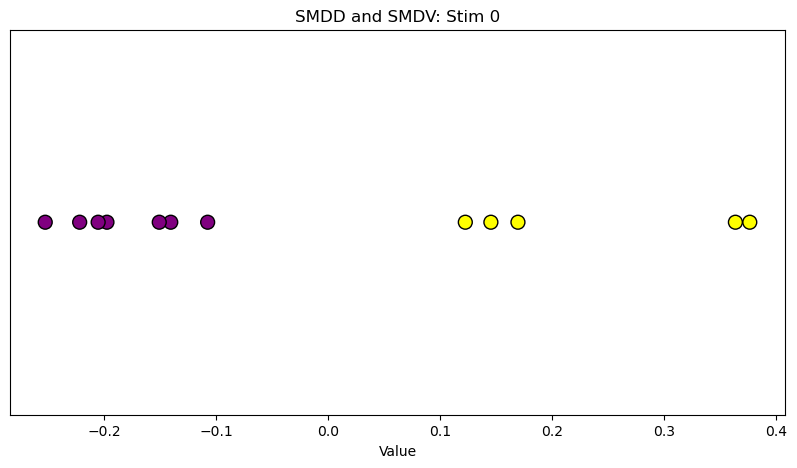

In [72]:
axis_trans_df.columns = ['Value', 'Category']

# Create a color map manually
color_map = {
    'SMDD': 'yellow',  
    'SMDV': 'purple'  
}

# Map labels to colors using the color map
label_colors = axis_trans_df['Category'].map(color_map)

# Create scatter plot with specified figure size
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(axis_trans_df['Value'], [0] * len(axis_trans_df),edgecolors='black', c=label_colors, s=100)
ax.set_xlabel('Value')
ax.yaxis.set_visible(False)

ax.set_title('SMDD and SMDV: Stim 0')

plt.show()



In [68]:
axis_trans_df

,Value,Category
0,0.122488,SMDD
1,0.145318,SMDD
2,0.169477,SMDD
3,0.363609,SMDD
4,0.376435,SMDD
5,-0.252541,SMDV
6,-0.221788,SMDV
7,-0.107537,SMDV
8,-0.14048,SMDV
9,-0.150743,SMDV


In [69]:
SMDD = axis_trans_df[axis_trans_df['Category'] == 'SMDD']['Value']
SMDV = axis_trans_df[axis_trans_df['Category'] == 'SMDV']['Value']





(array([[2., 2., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
         0., 0., 0., 2.]]),
 array([-0.25254106, -0.22109224, -0.18964342, -0.1581946 , -0.12674578,
        -0.09529696, -0.06384814, -0.03239932, -0.0009505 ,  0.03049832,
         0.06194714,  0.09339596,  0.12484478,  0.1562936 ,  0.18774242,
         0.21919124,  0.25064006,  0.28208888,  0.3135377 ,  0.34498652,
         0.37643534]),
 <a list of 2 list[Polygon] objects>)

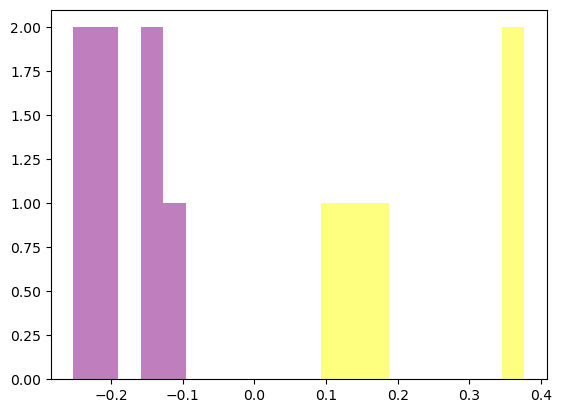

In [70]:
plt.hist([SMDV, SMDD], bins = 20, alpha=0.5, label=['SMDV', 'SMDD'], color = [ 'purple','yellow'], histtype='stepfilled')


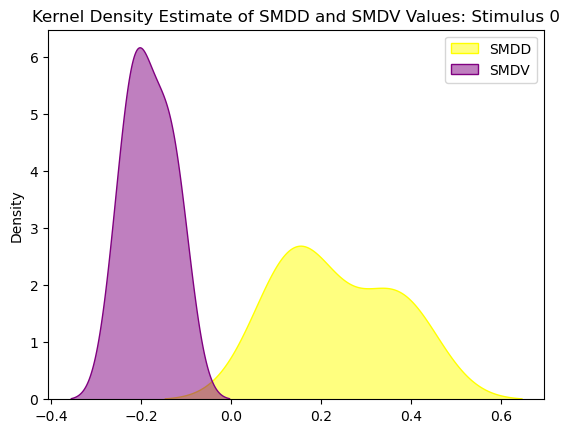

In [71]:
# Plotting KDE for each category
sns.kdeplot(SMDD, color='yellow', fill=True, alpha=0.5, label='SMDD')
sns.kdeplot(SMDV, color='purple', fill=True, alpha=0.5, label='SMDV')

# Adding labels and title
plt.xlabel('')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of SMDD and SMDV Values: Stimulus 0')
plt.legend()

# Show the plot
plt.show()

#what should the x-axis be?

In [ ]:
#look at distance between distributions, KS distance 

In [136]:
#use svm in 8 dim space 
#also try a logistic regression, using 8 dim tangent space data and correspoding labels
#try MNE on tangent space coords
y = data.iloc[:, -1]
X = data.iloc[:, 0:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [138]:
logreg = LogisticRegression(random_state=16)

# Train the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [139]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [140]:
y_pred = logreg.predict(X_test)

In [141]:
y_pred

array(['RME', 'RME', 'AVA', 'RME', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA',
       'AVA', 'AVA', 'AVA', 'RME', 'AVA', 'RME'], dtype=object)

In [143]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4, 1],
       [6, 4]])

NameError: name 'Text' is not defined

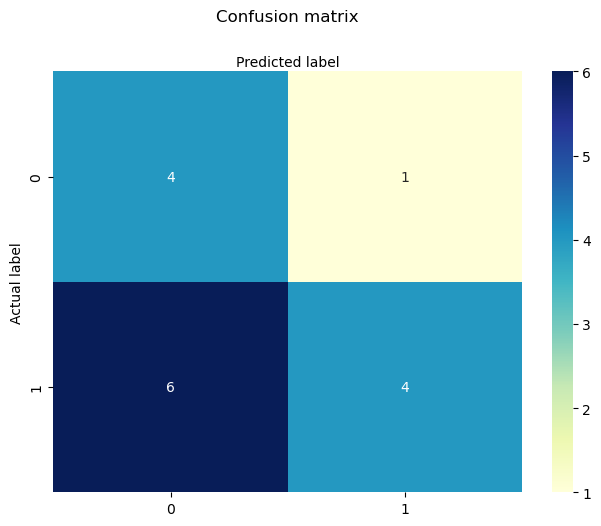

In [144]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label');

In [149]:
target_names = ['AVA', 'RME']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         AVA       0.40      0.80      0.53         5
         RME       0.80      0.40      0.53        10

    accuracy                           0.53        15
   macro avg       0.60      0.60      0.53        15
weighted avg       0.67      0.53      0.53        15

